# Chapter 6.1: Application to observational data from SISAL and iso2 (GMT and Precipitation)

- Compare GMT to PHYDA and LMR. Eventually also compute global precipitation curve.

Questions/Storyline:
- Phyda and LMR represent an independent reconstruction, based on independent data -> validation of reconstruction.
    - Tuning parameters to get it right/compare to:
        - Proxy error (0.5, 0.1?)
        - Time scale sensitivity
        - reuse proxies / no reuse
    - I get more meaningful results without the fractionation/filters
        - psm raw / fractionation / filters
    - Sisal
    - multi-model ensemble.
        
Plot 1: GMT- Curves (filtered, butterworth)

Plot 2: SISAL and Iso2k individual curves. Target DA.

-> Story: find the best option/configuration

Plot 3: Spectra of GMT curves: http://linked.earth/PyleoTutorials/notebooks/L2_spectral_analysis.html
        Compute Variance (Janica additional material)

Table 1: Correlation table 800-1850. Different models (5 + 2 MME + PHYDA, LMR)

Table 2: Correlation table 1850-2000. Different models (5 + 2 MME + PHYDA, LMR), unfiltered?

Plot 4: 1850 - 2000 GMT Curve (hier genauer, nicht filtern?)

Plot 5: Global mean precipitation curve (comparison to LMR, PHYDA hat sich nicht)

Appendix: 
    - Curves for individual models

   

LMR2 https://www.atmos.uw.edu/~hakim/lmr/LMRv2/index.html ()



In [1]:
import sys
sys.path.append('/home/mchoblet/paleoda')

import xarray as xr
import wrapper
import dataloader
import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature  
from matplotlib.offsetbox import AnchoredText    
import utils

import copy

%load_ext autoreload
%autoreload 2

In [2]:
#CONFIG DICTIONARY (NEW)

#lists are sometimes necessary, especially if we use multiple proxy-DBs (e.g. SISAL and iso2k)
#and multiple timescales
cfg={
'vp':{
'd18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'slp': None,
},
'avg':None,
'oro': '/home/mchoblet/paleoda/data/orographies/echam_oro.nc',
'reconstruct':['tsurf','d18O','prec','inf'],
'basepath':'/home/mchoblet/paleoda/', #dont forget last slash
'output_folder':'thesis_6_1', #in cwd
'output_file':'Echam_realistic_PPE_snr1',
'multi_model_prior': None, #None or a list where the first entry is a dictionary of dictionaries for the file paths and secord a dictionary with the orography files
'avg':None, 
'seed': 42, 
'check_nan':True, #mainly needed for iHadCM3, because of its missing years nans are introduced with 'resampled'
'obsdata':['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc'],
'obs_var':[['d18O','d18O_precision'],['d18O','d18O_precision']],
'how_many': None, 
'only_regional_proxies':False,
'regional_bounds':False,
'proxy_error': [0.5,0.5], 
'time_scales': ['median','median'],
'proxy_time':['0800','2013'],
'resample': True,
'resample_mode': 'nearest',
'mask': 3, 
###MULTI-TIMESCALE
#'timescales':[1,5,10,20], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'timescales':[1,5,10,20,50,100], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'reuse': True,

#'psm':['speleo','icecore'], 
'psm':[None,None], 
'interpol':None, #None/'dw'
'var_psm': ['d18O','d18O'] ,
#irrelevant if psm=none
'speleo':{
    'weighting': 'inf',#'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation': True, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'regular'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
},
'icecore':{
    'weighting':'prec', #None(pure d18O) / prec (d180 prec weighted)
    'height': False, #height correction: True requires orography of model and 'elev' coordinate for proxy_db. Requires that proxy_db has a coordinate 'lapse rate' (e.g. i attributed -0.15 to non polar porxies and -0.28 to polar ones (per 100m)
    'filter': False, #If True the PSM-function from PRYSM which takes into account diffusion is applied. 
},

###PSEUDOPROXY-EXPERIMENTS (variable comes from var_psm)
'ppe': {
    'use': False,
    },


###KALMAN-FILTER
'time': ['0800','1999'],
'nens':100, #ensemble members
'reps':10, #Monte Carlo
'full_fields': True, 
'proxy_frac': None,
'extra_assi': 
    {
        'globalmean': ['tsurf','d18O','prec','evap','inf'], #None or list of variables
        'lat_mean': ['tsurf'], #None, #['tsurf'], #None or list of variables
        'regionalmean': None, #None or list of variables
        'region':None, #None or list of list [[latS,latN],[latW,latE]] #specify the regions in 0-360 longitude system
        'prec_weighted': False, #if you want to get the precipitation weighted d18O
    },
'error_scale':1, 
'anomaly': 'BG+HX', #'BG+HX', #/ 'HX'
'anomaly_time': ['1700','1800'],#None, #['1600','1800'],#None,#['1500','1750'],#None,
'cov_loc': None,
#evaluation metrics (which do not rely on a true state)
'metrics': [None],#['rank_histogram','rank_histogram_posterior','CD'], #['None']
}

In [3]:
#upsampled multiprior
multi_prior_up={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/upsampled/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_slp_801_1952.nc',
       }
}

paths={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/CESM_inf_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/CCSM_inf_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/ECHAM5_inf_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/GISS_inf_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/iHADCM3_inf_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc',
       }
} 

oro_dic={
'iCESM':'/home/mchoblet/paleoda/data/orographies/icesm_oro.nc',
'isoGSM':'/home/mchoblet/paleoda/data/orographies/ccsm_oro.nc',
'Echam': '/home/mchoblet/paleoda/data/orographies/echam_oro.nc',
'GISS':'/home/mchoblet/paleoda/data/orographies/giss_oro.nc',
'iHadCM3':'/home/mchoblet/paleoda/data/orographies/hadcm3_oro.nc',
}

#paths to all models (downsampled to Echam resolution)
multi_prior_ds={
    'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_inf_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_slp_801_1952.nc',
       },
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_inf_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_inf_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_inf_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_inf_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc',
       },
}


# Experiments:

MME: downsampled for speed issues multi_prior_ds

First:
- 0.5 proxy error
- reuse records
- [1,5,10,20,50,100]
- Anomaly: 'BG+HX'
- Fractionation and Inf + Prec weighting
- SISAL and ISO joint and separate

Second:
- Same as first, just no psm at all, pure signal

Third:
- Same as first
- no debiasing -> Absolute values. Full-PSM without the filter?
- probably results get inconsistent, but that's that I wann a show

In [4]:
def experiments(cfg,option):    
    #paths=multi_prior_up
    #loop over proxy origin
    for i, model in enumerate(paths.keys()):
        #pseudoproxy source
        cfg_exp=copy.deepcopy(cfg)
        cfg_exp['multi_model_prior']=None

        if model=='iHadCM3':
            cfg_exp['check_nan']=True
        else:
            cfg_exp['check_nan']=False

        cfg_exp['vp']=paths[model]
        #both databases
        cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
        cfg_exp['output_file']=model+'_both'
        wrapper.paleoda_wrapper(cfg_exp)

        #only sisal records
        cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc']
        cfg_exp['psm']=[None]
        cfg_exp['output_file']=model+'_sisal'
        wrapper.paleoda_wrapper(cfg_exp)

        #only iso2k ice cores
        cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
        cfg_exp['psm']=[None]
        cfg_exp['output_file']=model+'_iso'
        wrapper.paleoda_wrapper(cfg_exp)

    #MULTI-MODEL-ENSEMBLE
    copied_paths=copy.deepcopy(multi_prior_ds)
    cfg_exp['multi_model_prior']=copied_paths

    #both databases
    cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
    cfg_exp['psm']=[None,None]
    cfg_exp['output_file']='mme_both'
    wrapper.paleoda_wrapper(cfg_exp)

    #only sisal records
    cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc']
    cfg_exp['psm']=[None]
    cfg_exp['output_file']='mme_sisal'
    wrapper.paleoda_wrapper(cfg_exp)

    #only iso2k ice cores
    cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
    cfg_exp['psm']=[None]
    cfg_exp['output_file']='mme_iso'
    wrapper.paleoda_wrapper(cfg_exp)

    #MULTI-MODEL-ENSEMBLE (no GISS)
    copied_paths=copy.deepcopy(multi_prior_ds)
    cfg_exp['multi_model_prior']=copied_paths
    del copied_paths['GISS']

    #both databases
    cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
    cfg_exp['psm']=[None,None]
    cfg_exp['output_file']='mme_nogiss_both'
    wrapper.paleoda_wrapper(cfg_exp)

    #only sisal records
    cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc']
    cfg_exp['psm']=[None]
    cfg_exp['output_file']='mme_nogiss_sisal'
    wrapper.paleoda_wrapper(cfg_exp)

    #only iso2k ice cores
    cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
    cfg_exp['psm']=[None]
    cfg_exp['output_file']='mme_nogiss_iso'
    wrapper.paleoda_wrapper(cfg_exp)
    

In [ ]:
### EXP 0: PSM LIGHT

cfg['speleo']['weighting']='inf'
cfg['speleo']['fractionation']=True
cfg['speleo']['filter']=False
cfg['icecore']['weighting']='prec'
cfg['icecore']['filter']= False
cfg['psm']=['speleo','icecore']

cfg['output_folder']='thesis_6_1_0'
#experiments(cfg)

for i, model in enumerate(paths.keys()):
    #pseudoproxy source
    cfg_exp=copy.deepcopy(cfg)
    cfg_exp['multi_model_prior']=None

    if model=='iHadCM3':
        cfg_exp['check_nan']=True
    else:
        cfg_exp['check_nan']=False

    cfg_exp['vp']=paths[model]
    #both databases
    cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
    cfg_exp['output_file']=model+'_both'
    wrapper.paleoda_wrapper(cfg_exp)

    #only sisal records
    cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc']
    cfg_exp['psm']=['speleo']
    cfg_exp['output_file']=model+'_sisal'
    wrapper.paleoda_wrapper(cfg_exp)

    #only iso2k ice cores
    cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
    cfg_exp['psm']=['icecore']
    cfg_exp['output_file']=model+'_iso'
    wrapper.paleoda_wrapper(cfg_exp)

#MULTI-MODEL-ENSEMBLE
copied_paths=copy.deepcopy(multi_prior_ds)
cfg_exp['multi_model_prior']=copied_paths
cfg_exp['check_nan']=True
#both databases
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
cfg_exp['psm']=['speleo','icecore']
cfg_exp['output_file']='mme_both'
wrapper.paleoda_wrapper(cfg_exp)

#only sisal records
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc']
cfg_exp['psm']=['speleo']
cfg_exp['output_file']='mme_sisal'
wrapper.paleoda_wrapper(cfg_exp)

#only iso2k ice cores
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
cfg_exp['psm']=['icecore']
cfg_exp['output_file']='mme_iso'
wrapper.paleoda_wrapper(cfg_exp)

#MULTI-MODEL-ENSEMBLE (no GISS)
copied_paths=copy.deepcopy(multi_prior_ds)
cfg_exp['multi_model_prior']=copied_paths
del copied_paths['GISS']

#both databases
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
cfg_exp['psm']=['speleo','icecore']
cfg_exp['output_file']='mme_nogiss_both'
wrapper.paleoda_wrapper(cfg_exp)

#only sisal records
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc']
cfg_exp['psm']=['speleo']
cfg_exp['output_file']='mme_nogiss_sisal'
wrapper.paleoda_wrapper(cfg_exp)

#only iso2k ice cores
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
cfg_exp['psm']=['icecore']
cfg_exp['output_file']='mme_nogiss_iso'
wrapper.paleoda_wrapper(cfg_exp)


>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 109/109 [00:15<00:00,  6.82it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/CESM_inf_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [1:07:13<00:00, 403.32s/it]


Finished multitimescale DA
Save variables
Output written to iCESM_both.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 108/108 [00:28<00:00,  3.80it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/CESM_inf_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [1:18:16<00:00, 469.62s/it]


Finished multitimescale DA
Save variables
Output written to iCESM_sisal.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 109/109 [00:22<00:00,  4.95it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/CESM_inf_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [1:21:42<00:00, 490.28s/it]


Finished multitimescale DA
Save variables
Output written to iCESM_iso.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 109/109 [00:22<00:00,  4.81it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/CCSM_inf_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [1:43:20<00:00, 620.06s/it]


Finished multitimescale DA
Save variables
Output written to isoGSM_both.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 108/108 [00:28<00:00,  3.73it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/CCSM_inf_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [1:41:17<00:00, 607.72s/it]


Finished multitimescale DA
Save variables
Output written to isoGSM_sisal.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 109/109 [00:22<00:00,  4.92it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/CCSM_inf_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [1:32:59<00:00, 557.97s/it]


Finished multitimescale DA
Save variables
Output written to isoGSM_iso.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 109/109 [00:16<00:00,  6.71it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_inf_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [19:29<00:00, 116.96s/it]


Finished multitimescale DA
Save variables
Output written to Echam_both.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 108/108 [00:27<00:00,  3.94it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_inf_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [26:07<00:00, 156.71s/it]


Finished multitimescale DA
Save variables
Output written to Echam_sisal.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 109/109 [00:15<00:00,  7.26it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_inf_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [24:08<00:00, 144.82s/it]


Finished multitimescale DA
Save variables
Output written to Echam_iso.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 109/109 [00:20<00:00,  5.42it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/GISS_inf_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [1:08:40<00:00, 412.01s/it]


Finished multitimescale DA
Save variables
Output written to GISS_both.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 108/108 [00:27<00:00,  3.97it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/GISS_inf_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [1:30:58<00:00, 545.84s/it]


Finished multitimescale DA
Save variables
Output written to GISS_sisal.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 109/109 [00:21<00:00,  4.96it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/GISS_inf_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 10/10 [1:28:26<00:00, 530.66s/it]


Finished multitimescale DA
Save variables
Output written to GISS_iso.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 109/109 [00:26<00:00,  4.14it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load inf  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_inf_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in

100%|██████████| 10/10 [28:54<00:00, 173.43s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3_both.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 108/108 [00:25<00:00,  4.31it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load inf  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_inf_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in

100%|██████████| 10/10 [40:33<00:00, 243.35s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3_sisal.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 109/109 [00:21<00:00,  5.03it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load inf  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_inf_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in

100%|██████████| 10/10 [40:14<00:00, 241.46s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3_iso.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 109/109 [00:24<00:00,  4.48it/s]


Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load inf  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_inf_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year

 10%|█         | 1/10 [17:57<2:41:40, 1077.79s/it]

In [14]:
#testweise
cfg['reps']=1
cfg['nens']=40

In [15]:
cfg['speleo']['weighting']='inf'
cfg['speleo']['fractionation']=True
cfg['speleo']['filter']=False
cfg['icecore']['weighting']='prec'
cfg['icecore']['filter']= False
cfg['psm']=['speleo','icecore']

cfg['output_folder']='thesis_6_1_0'
cfg_exp=copy.deepcopy(cfg)
cfg_exp['check_nan']=True

In [16]:
### just let the nogiss model mme 

#MULTI-MODEL-ENSEMBLE (no GISS)

copied_paths=copy.deepcopy(multi_prior_ds)
cfg_exp['multi_model_prior']=copied_paths
del copied_paths['GISS']

#both databases
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
cfg_exp['psm']=['speleo','icecore']
cfg_exp['output_file']='mme_nogiss_both'
wrapper.paleoda_wrapper(cfg_exp)

#only sisal records
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc']
cfg_exp['psm']=['speleo']
cfg_exp['output_file']='mme_nogiss_sisal'
wrapper.paleoda_wrapper(cfg_exp)

#only iso2k ice cores
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
cfg_exp['psm']=['icecore']
cfg_exp['output_file']='mme_nogiss_iso'
wrapper.paleoda_wrapper(cfg_exp)

>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 109/109 [00:14<00:00,  7.38it/s]


Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load inf  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_inf_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year

ipdb>  values_vector


array([[ 1.40627081,  1.11040096,  0.82177912, ...,  0.05895286,
         0.13413745, -0.21773319],
       [-1.2123897 , -1.13884372, -1.35106267, ..., -0.27923573,
        -0.22595401, -0.46035425],
       [-2.12564882, -2.08122181, -2.09155142, ..., -0.1423769 ,
        -0.15315894,  0.45984102],
       ...,
       [ 3.08440962,  3.27975674,  3.49355948, ...,  1.79604943,
         1.62114119,  2.23958175],
       [ 3.95672516,  3.98961021,  3.97371819, ...,  1.40041208,
         1.24691777,  1.67692602],
       [ 3.98826584,  4.19185781,  4.20413747, ...,  1.72868979,
         1.7050494 ,  1.80415703]])


ipdb>  np.isnan(values_vector)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])


ipdb>  np.count_nonzero(np.isnan(values_vector))


0


ipdb>  c


Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load inf  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_inf_801_1952.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
COMPUTE ANOMALIES IN MODE: BG+HX
> /home/mchoblet/paleoda/wrapper.py(85)paleoda_wrapper()
     83     MC_idx_list=[]
     84 
---> 85     for i in range(ran):
     86         #for multi-model prior option change the paths and the
     87         

ipdb>  np.count_nonzero(np.isnan(values_vector))


2125411


ipdb>  q


BdbQuit: 

In [ ]:
np.arange(5)

In [ ]:

### EXP 1: THE PURE SIGNAL (I hope/expect that the results are very close to EXP 0)

cfg['output_folder']='thesis_6_1_1'
#experiments(cfg)

for i, model in enumerate(paths.keys()):
    #pseudoproxy source
    cfg_exp=copy.deepcopy(cfg)
    cfg_exp['multi_model_prior']=None

    if model=='iHadCM3':
        cfg_exp['check_nan']=True
    else:
        cfg_exp['check_nan']=False

    cfg_exp['vp']=paths[model]
    #both databases
    cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
    cfg_exp['output_file']=model+'_both'
    wrapper.paleoda_wrapper(cfg_exp)

    #only sisal records
    cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc']
    cfg_exp['psm']=[None]
    cfg_exp['output_file']=model+'_sisal'
    wrapper.paleoda_wrapper(cfg_exp)

    #only iso2k ice cores
    cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
    cfg_exp['psm']=[None]
    cfg_exp['output_file']=model+'_iso'
    wrapper.paleoda_wrapper(cfg_exp)

#MULTI-MODEL-ENSEMBLE
copied_paths=copy.deepcopy(multi_prior_ds)
cfg_exp['multi_model_prior']=copied_paths

#both databases
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
cfg_exp['psm']=[None,None]
cfg_exp['output_file']='mme_both'
wrapper.paleoda_wrapper(cfg_exp)

#only sisal records
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc']
cfg_exp['psm']=[None]
cfg_exp['output_file']='mme_sisal'
wrapper.paleoda_wrapper(cfg_exp)

#only iso2k ice cores
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
cfg_exp['psm']=[None]
cfg_exp['output_file']='mme_iso'
wrapper.paleoda_wrapper(cfg_exp)

#MULTI-MODEL-ENSEMBLE (no GISS)
copied_paths=copy.deepcopy(multi_prior_ds)
cfg_exp['multi_model_prior']=copied_paths
del copied_paths['GISS']

#both databases
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
cfg_exp['psm']=[None,None]
cfg_exp['output_file']='mme_nogiss_both'
wrapper.paleoda_wrapper(cfg_exp)

#only sisal records
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc']
cfg_exp['psm']=[None]
cfg_exp['output_file']='mme_nogiss_sisal'
wrapper.paleoda_wrapper(cfg_exp)

#only iso2k ice cores
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
cfg_exp['psm']=[None]
cfg_exp['output_file']='mme_nogiss_iso'
wrapper.paleoda_wrapper(cfg_exp)



In [ ]:
### EXP 2: ABSOLUTE VALUES! (FIRST ONLY PSM LIGHT) -> will it be crappy?

cfg['anomaly']=None
cfg['anomaly_time']=None



cfg['speleo']['weighting']='inf'
cfg['speleo']['fractionation']=True
cfg['speleo']['filter']=False
cfg['icecore']['weighting']='prec'
cfg['icecore']['filter']= False
cfg['psm']=['speleo','icecore']

cfg['output_folder']='thesis_6_1_2'
#experiments(cfg)

for i, model in enumerate(paths.keys()):
    #pseudoproxy source
    cfg_exp=copy.deepcopy(cfg)
    cfg_exp['multi_model_prior']=None

    if model=='iHadCM3':
        cfg_exp['check_nan']=True
    else:
        cfg_exp['check_nan']=False

    cfg_exp['vp']=paths[model]
    #both databases
    cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
    cfg_exp['output_file']=model+'_both'
    wrapper.paleoda_wrapper(cfg_exp)

    #only sisal records
    cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc']
    cfg_exp['psm']=['speleo']
    cfg_exp['output_file']=model+'_sisal'
    wrapper.paleoda_wrapper(cfg_exp)

    #only iso2k ice cores
    cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
    cfg_exp['psm']=['icecore']
    cfg_exp['output_file']=model+'_iso'
    wrapper.paleoda_wrapper(cfg_exp)

#MULTI-MODEL-ENSEMBLE
copied_paths=copy.deepcopy(multi_prior_ds)
cfg_exp['multi_model_prior']=copied_paths

#both databases
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
cfg_exp['psm']=['speleo','icecore']
cfg_exp['output_file']='mme_both'
wrapper.paleoda_wrapper(cfg_exp)

#only sisal records
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc']
cfg_exp['psm']=['speleo']
cfg_exp['output_file']='mme_sisal'
wrapper.paleoda_wrapper(cfg_exp)

#only iso2k ice cores
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
cfg_exp['psm']=['icecore']
cfg_exp['output_file']='mme_iso'
wrapper.paleoda_wrapper(cfg_exp)

#MULTI-MODEL-ENSEMBLE (no GISS)
copied_paths=copy.deepcopy(multi_prior_ds)
cfg_exp['multi_model_prior']=copied_paths
del copied_paths['GISS']

#both databases
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
cfg_exp['psm']=['speleo','icecore']
cfg_exp['output_file']='mme_nogiss_both'
wrapper.paleoda_wrapper(cfg_exp)

#only sisal records
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc']
cfg_exp['psm']=['speleo']
cfg_exp['output_file']='mme_nogiss_sisal'
wrapper.paleoda_wrapper(cfg_exp)

#only iso2k ice cores
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
cfg_exp['psm']=['icecore']
cfg_exp['output_file']='mme_nogiss_iso'
wrapper.paleoda_wrapper(cfg_exp)


In [385]:
#MULTI-MODEL-ENSEMBLE (no GISS)
cfg_exp=copy.deepcopy(cfg)
cfg_exp['check_nan']=True

copied_paths=copy.deepcopy(multi_prior_up)
cfg_exp['multi_model_prior']=copied_paths
del copied_paths['GISS']

#both databases
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
cfg_exp['psm']=[None,None]
cfg_exp['output_file']='mme_nogiss_both'
wrapper.paleoda_wrapper(cfg_exp)

#only sisal records
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc']
cfg_exp['psm']=[None]
cfg_exp['output_file']='mme_nogiss_sisal'
wrapper.paleoda_wrapper(cfg_exp)

#only iso2k ice cores
cfg_exp['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc']
cfg_exp['psm']=[None]
cfg_exp['output_file']='mme_nogiss_iso'
wrapper.paleoda_wrapper(cfg_exp)

>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 109/109 [00:12<00:00,  8.39it/s]


Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_tsurf_851_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE

100%|██████████| 1/1 [00:16<00:00, 16.11s/it]


Finished multitimescale DA
Save variables
Output written to mme_nogiss_both.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 108/108 [00:15<00:00,  7.16it/s]


Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_tsurf_851_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE

100%|██████████| 1/1 [00:14<00:00, 14.92s/it]


Finished multitimescale DA
Save variables
Output written to mme_nogiss_sisal.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 109/109 [00:13<00:00,  8.34it/s]


Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CCSM_tsurf_851_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE

100%|██████████| 1/1 [00:14<00:00, 14.96s/it]

Finished multitimescale DA
Save variables
Output written to mme_nogiss_iso.nc


<xarray.Dataset>
Dimensions:          (model: 4, reps: 1, nens: 100, site: 109, time: 1200,
                      bs: 100, lat: 94, time_res_1: 1200, site_1: 80,
                      time_res_5: 240, site_5: 84, time_res_10: 120,
                      site_10: 97, time_res_20: 60, site_20: 106,
                      time_res_50: 24, site_50: 107, time_res_100: 12,
                      site_100: 109)
Coordinates: (12/14)
    MC_idx           (model, reps, nens) int64 385 827 588 398 ... 995 460 812
  * site             (site) <U5 '0.127' '0.103' '0.45' ... '0.128' '0.111'
  * time_res_1       (time_res_1) object 0800-01-01 00:00:00 ... 1999-01-01 0...
  * site_1           (site_1) <U5 '0.127' '0.103' '0.45' ... '0.128' '0.111'
  * time_res_5       (time_res_5) object 0800-01-01 00:00:00 ... 1995-01-01 0...
  * site_5           (site_5) <U5 '0.127' '0.103' '0.45' ... '0.128' '0.111'
    ...               ...
  * time_res_20      (time_res_20) object 0800-01-01 00:00:00 ... 1980-01-01 ...
  * site_20          (site_20) <U5 '0.127' '0.103' '0.45' ... '0.128' '0.111'
  * time_res_50      (time_res_50) object 0800-01-01 00:00:00 ... 1950-01-01 ...
  * site_50          (site_50) <U5 '0.127' '0.103' '0.45' ... '0.128' '0.111'
  * time_res_100     (time_res_100) object 0800-01-01 00:00:00 ... 1900-01-01...
  * site_100         (site_100) <U5 '0.127' '0.103' '0.45' ... '0.128' '0.111'
Dimensions without coordinates: model, reps, nens, time, bs, lat
Data variables: (12/22)
    HXf_m            (time, site) float64 1.821 1.821 1.831 ... -0.6117 -0.6944
    HXf_std          (time, site) float64 1.821 1.821 1.831 ... -0.6117 -0.6944
    HXf_prior_m      (bs, site) float64 -0.5008 -0.5008 ... -0.6117 -0.6944
    HXf_prior_std    (bs, site) float64 0.3141 0.3141 0.3178 ... 0.6268 0.5942
    gm_tsurf         (time) float64 0.2006 0.248 0.2487 ... 0.9636 0.8682 0.7897
    gm_tsurf_std     (time) float64 0.2088 0.1964 0.1744 ... 0.1988 0.2178
    ...               ...
    proxies_res_50   (time_res_50, site_50) float64 0.2821 nan ... 0.4854 0.5187
    proxies_res_100  (time_res_100, site_100) float64 0.2324 nan ... 0.3755
    proxies          (time, site) float64 -43.14 nan nan nan ... nan nan nan nan
    proxies_r        (time, site) float64 0.5 nan nan nan ... nan nan nan nan
    proxies_lat      (site) float64 -75.0 -75.0 -74.88 ... -75.0 -75.58 -75.17
    proxies_lon      (site) float64 0.01 0.04 1.6 4.8 ... 355.5 356.6 359.0
Attributes:
    prior:    [{'grid_mapping': 'spatial_ref'}, {'units': 'mm/month'}, {'unit...
    cfg:      {'vp': {'d18O': '/home/mchoblet/paleoda/data/model_data/ECHAM5_...

In [ ]:
def gmt_together(folder='/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/', names=['Echam','GISS','iCESM','isoGSM','iHadCM3','mme','mme_nogiss'],cutoff=1/30,
                reference=reference,
                database='_both'
                title='GMT reconcstruction records (wrt 1800-1850 mean)',
                anotime=('1800','1850')
                ):
    """
    Which timescales are used? First 1,5,10,20,40
    """
    fig=plt.figure(figsize=(16,12))
    plt.locator_params(nbins=10)
    colors=np.concatenate([sns.color_palette('colorblind', n_colors=(len(names)-1)),[(0,0,0)]])
    plt.title(title, fontsize=40)
    
    for i,n in enumerate(names):
        string=folder + n + database+'.nc'
        tsurf=xr.open_dataset(string)['gm_tsurf']
        #compute anomaly
        tsurf=tsurf.sel(time=slice())
        
        
        tsurf=quick_filt(tsurf-tsurf[1000:1050].mean('time'),cutoff=cutoff)
        #choose different cut off
        std=quick_filt(xr.open_dataset(string)['gm_tsurf_std'],cutoff=1/40)
        plt.plot(tsurf,label=n, color=colors[i])
        #plt.fill_between(tsurf, tsurf - std, tsurf + std, color=colors[i], alpha=0.2)
    
    #plot reference dataset (LMR v2 z.B)
    
    
    plt.ylabel(r'$\Delta$ T',fontsize=28)
    plt.legend(loc='lower right',fontsize=22)
    plt.xticks(ticks=np.arange(0,1200,200),labels=list(map(str,np.arange(800,2000,200))),fontsize=28)
    return fig
    
def gmt_separate(folder='/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/', names=['Echam','GISS','iCESM','isoGSM','iHadCM3'],paths=downsampled_paths):
    """
    Which timescales are used? First 1,5,10,20,40
    """
    colors=sns.color_palette('colorblind', n_colors=2)
    
    for i,n in enumerate(names):
        plt.figure(figsize=(12,8))
        plt.locator_params(nbins=10)
        plt.title(('GMT for model '+n), fontsize=30)
        
        string=folder + n + '_800_1999.nc'
        tsurf=xr.open_dataset(string)['gm_tsurf']
        tsurf=quick_filt(tsurf-tsurf[800:1000].mean('time'))
        std=quick_filt(xr.open_dataset(string)['gm_tsurf_std'],cutoff=1/40)
        plt.plot(np.arange(len(tsurf)),tsurf,label='reconstruction', color=colors[0])
    
        #load prior model
        tsurf=dataloader.annual_mean(xr.open_dataset(paths[n]['tsurf'])['tsurf'],check_nan=True)
        tsurf=utils.globalmean(tsurf)
        tsurf=quick_filt(tsurf-tsurf.sel(time=slice('1600','1800')).mean('time'))
    
        plt.plot(np.arange(len(tsurf)),tsurf,label='model', color=colors[1])
        plt.ylabel(r'$\Delta$ T',fontsize=30)
        plt.legend(loc='lower right',fontsize=28)
        
        plt.xticks(ticks=np.arange(0,1200,200),labels=list(map(str,np.arange(800,2000,200))),fontsize=25)
        plt.show()
        
def gmt_separate_all(folder1='/home/mchoblet/paleoda/results/experiments/GMT_from_icecores/', folder2='/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/',
                     folder3='/home/mchoblet/paleoda/results/experiments/GMT_from_allproxies/',
                     names=['Echam','GISS','iCESM','isoGSM','iHadCM3'],paths=downsampled_paths):
    """
    Which timescales are used? First 1,5,10,20,40
    """
    colors=np.concatenate([sns.color_palette('colorblind', n_colors=3),[(0,0,0)]])
    
    for i,n in enumerate(names):
        plt.figure(figsize=(12,8))
        plt.locator_params(nbins=10)
        plt.title(('GMT for model '+n + '(wrt. 1800-1850)'), fontsize=20)
        
        #icecores
        string=folder1 + n + '_800_1999.nc'
        tsurf=xr.open_dataset(string)['gm_tsurf']
        tsurf=quick_filt(tsurf-tsurf[1000:1050].mean('time'))
        std=quick_filt(xr.open_dataset(string)['gm_tsurf_std'],cutoff=1/40)
        plt.plot(np.arange(len(tsurf)),tsurf,label='reconstruction (Iso2k)', color=colors[0])
        
        #speleos
        string=folder2 + n + '_800_1999.nc'
        tsurf=xr.open_dataset(string)['gm_tsurf']
        tsurf=quick_filt(tsurf-tsurf[1000:1050].mean('time'))
        std=quick_filt(xr.open_dataset(string)['gm_tsurf_std'],cutoff=1/40)
        plt.plot(np.arange(len(tsurf)),tsurf,label='reconstruction (Sisalv2)', color=colors[1])
    
        #together 
        string=folder3 + n + '_800_1999.nc'
        tsurf=xr.open_dataset(string)['gm_tsurf']
        tsurf=quick_filt(tsurf-tsurf[1000:1050].mean('time'))
        std=quick_filt(xr.open_dataset(string)['gm_tsurf_std'],cutoff=1/40)
        plt.plot(np.arange(len(tsurf)),tsurf,label='reconstruction (Sisalv2 + Iso2k)', color=colors[2])
    
        #load prior model
        if n=='iHadCM3':
            check=True
        else:
            check=False
        
        tsurf=dataloader.annual_mean(xr.open_dataset(paths[n]['tsurf'])['tsurf'],check_nan=check)
        tsurf=utils.globalmean(tsurf)
        tsurf=quick_filt(tsurf-tsurf.sel(time=slice('1800','1850')).mean('time'))
    
        plt.plot(np.arange(len(tsurf)),tsurf,label='model', color=colors[3])
    
        plt.ylabel(r'$\Delta$ T')
        plt.legend(loc='lower right')
        
        plt.xticks(ticks=np.arange(0,1200,200),labels=list(map(str,np.arange(800,2000,200))))
        plt.show()

In [ ]:
/home/mchoblet/paleoda/results/experiments/thesis_6_1_05_reuse/Echam_both.nc

# Anomaly, Filtering, Loading PHYDA and LMR 

In [92]:
def anomaly(ds,start='1800',end='1850'):
    """
    start='1850'
    end='1900'
    """
    ds=ds-ds.sel(time=slice(start,end)).mean('time')
    return ds

def quick_filt(ts,cutoff=1/30):
    from scipy.signal import butter, lfilter, filtfilt

    def butter_lowpass(cutoff, fs, order=6, kf=1.2):
        # kf:  scaling factor for the lowpass frequency; 1 = Nyquist, 1.2 =
        #' 1.2xNyquist is a tradeoff between reducing variance loss and keeping
        #' aliasing small
        #fs is basic timestep (min_ts)
        #nyquist frequency
        nyq = 0.5 * fs 
        normal_cutoff = cutoff / nyq * kf
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(data, cutoff, fs, order=6):
        #filtfilt does not introduce a time-lag in comparison to butterworth 
        b, a = butter_lowpass(cutoff, fs, order=order)
        y = filtfilt(b, a, data)
        #y = lfilter(b, a, data)
        return y

    return butter_lowpass_filter(ts,cutoff,fs=1,order=4)


In [189]:
phyda_path='/home/mchoblet/lmr_phyda_output/phyda.nc'
phyda=xr.open_dataset(phyda_path)
LMR_tsurf_m='/home/mchoblet/lmr_phyda_output/air_MCruns_ensemble_mean_LMRv2.1.nc'
LMR_tsurf_s='/home/mchoblet/lmr_phyda_output/air_MCruns_ensemble_spread_LMRv2.1.nc'
LMR_gmt='/home/mchoblet/lmr_phyda_output/gmt_MCruns_ensemble_full_LMRv2.1.nc'
lmr_gm=xr.open_dataset(LMR_gmt)
time_lmr=lmr_gm['time']
time_phyda=time_lmr[1:]
phyda['time']=time_phyda
phyda=phyda.sel(time=slice('0800','2000'))
lmr_gm=lmr_gm.sel(time=slice('0800','2000'))


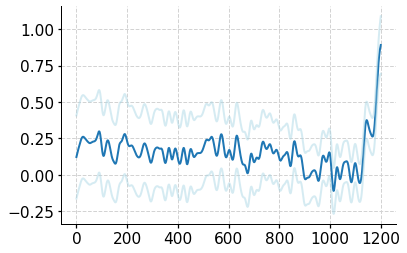

In [203]:
filtered=quick_filt(anomaly(phyda['gmt_mn']).values)
std=quick_filt(phyda['gmt_sg'].values)
plt.plot(filtered)

plt.plot(filtered+std*2,color='lightblue',alpha=0.5)
plt.plot(filtered-std*2,color='lightblue',alpha=0.5)

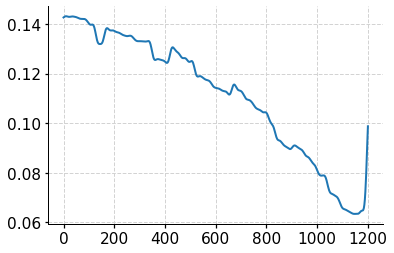

In [184]:
#precipitation
lmr_prec='/home/mchoblet/lmr_phyda_output/prate_MCruns_ensemble_mean_LMRv2.1.nc'
lmr_prec=xr.open_dataset(lmr_prec).mean('MCrun')['prate']
#convert lmr_prec from kg/(m2*s) to mm/month()
lmr_prec=lmr_prec*60*24*60*31
lmr_prec_gm=utils.globalmean(lmr_prec)

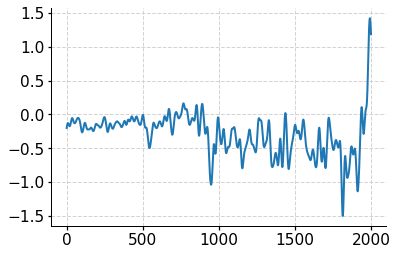

In [185]:
plt.plot(quick_filt(lmr_prec_gm))

In [168]:
lmr_prec

<xarray.Dataset>
Dimensions:  (time: 2001, lat: 91, lon: 180)
Coordinates:
  * time     (time) object 0000-01-01 00:00:00 ... 2000-01-01 00:00:00
  * lat      (lat) float32 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Data variables:
    prate    (time, lat, lon) float32 -1.923e-08 -1.923e-08 ... 4.569e-07

In [355]:
hadcrut='/home/mchoblet/validation_data/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc'
hadcrut=xr.open_dataset(hadcrut)
hadcrut=hadcrut.rename({'latitude':'lat','longitude':'lon'})
gm_hadcrut=utils.globalmean(dataloader.annual_mean(hadcrut['tas_mean']))

In [140]:
pages2k_2019='/home/mchoblet/lmr_phyda_output/pages2k_ngeo19_recons.nc'
pages2k=xr.open_dataset(pages2k_2019)
pages2k=pages2k.rename({'year':'time'})
pages2k['time']=time_phyda
pages2k=pages2k.sel(time=slice('0800','2000'))
p2k_m=pages2k.mean('ens')
p2k_s=pages2k.std('ens')

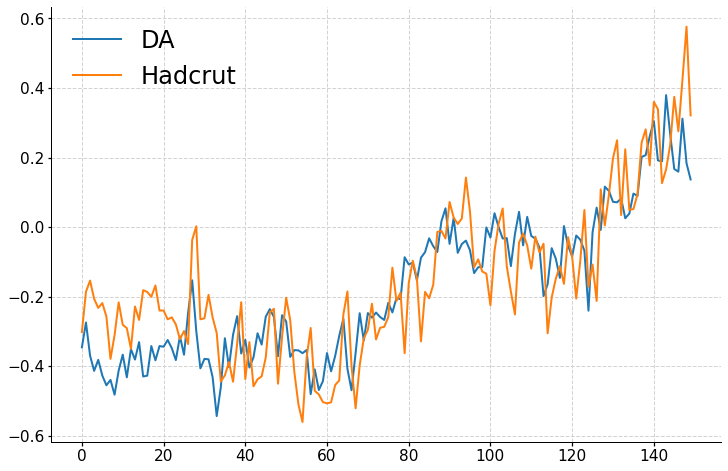

In [366]:
plt.figure(figsize=(12,8))
plt.plot(pages2k['DA'][1850:].mean('ens'),label='DA')
#plt.plot(pages2k['CPS'][1850:].mean('ens'),label='CPS')
plt.plot(gm_hadcrut[:150],label='Hadcrut')
plt.legend()

In [ ]:
gm_hadcrut

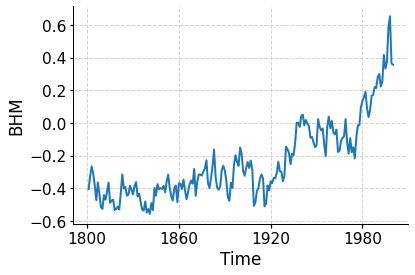

In [340]:
pages2k['BHM'][1800:].mean('ens').plot()

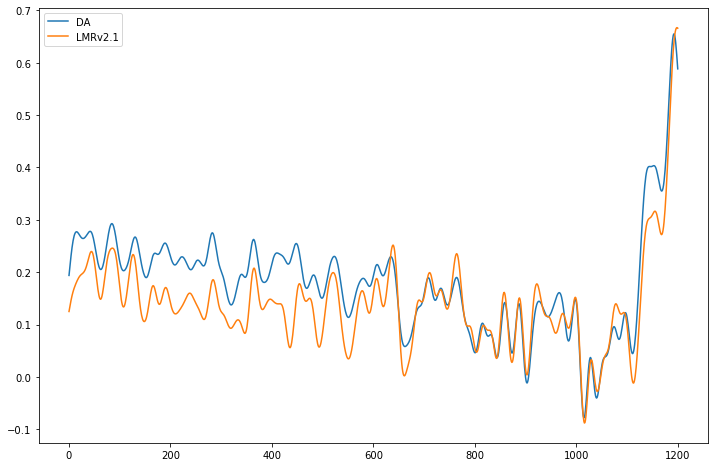

In [141]:
plt.figure(figsize=(12,8))
v='DA'
plt.plot(quick_filt(anomaly(p2k_m[v])),label=v)
v='LMRv2.1'
plt.plot(quick_filt(anomaly(p2k_m[v])),label=v)
plt.legend()

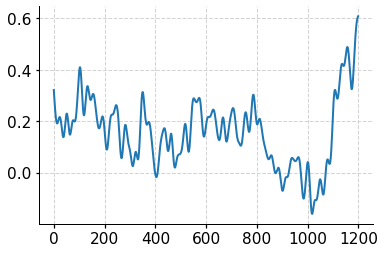

In [393]:
plt.plot(quick_filt(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_1_05_reuse/mme_both.nc')['gm_tsurf']))

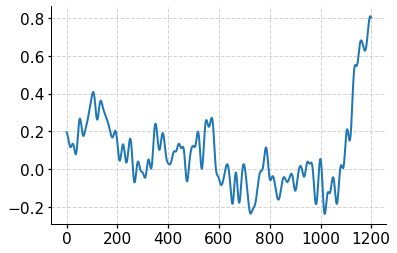

In [397]:
plt.plot(quick_filt(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_1_05_reuse/mme_nogiss_iso.nc')['gm_tsurf']))

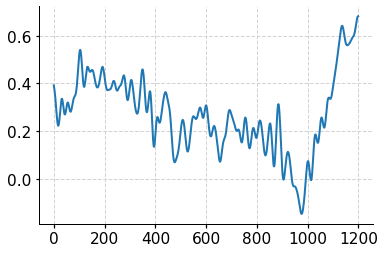

In [395]:
plt.plot(quick_filt(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_1_05_reuse/iCESM_both.nc')['gm_tsurf']))

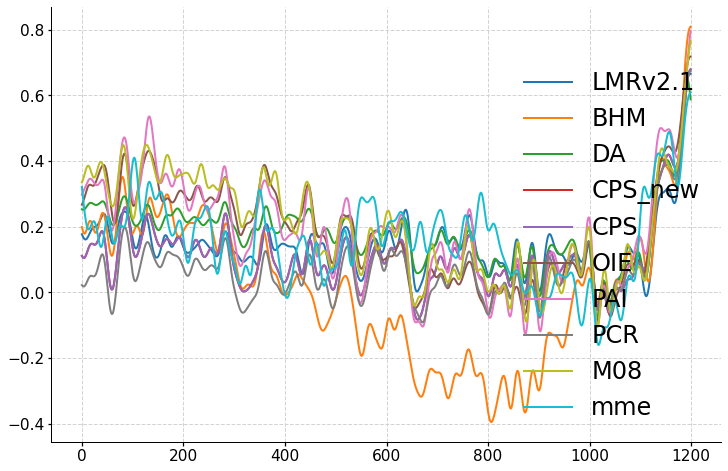

In [398]:
plt.figure(figsize=(12,8))
for v in p2k_m.data_vars:
    plt.plot(quick_filt(anomaly(p2k_m[v]))[800:],label=v)

plt.legend()

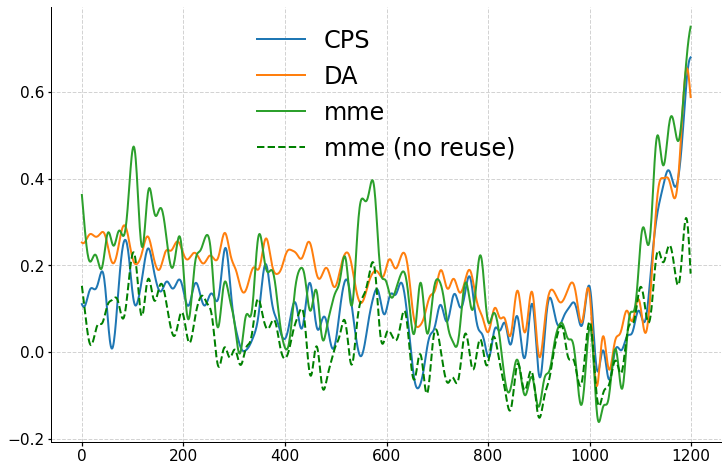

In [436]:
plt.figure(figsize=(12,8))
v='CPS'
plt.plot(quick_filt(anomaly(p2k_m[v]))[800:],label=v)

v='DA'
plt.plot(quick_filt(anomaly(p2k_m[v]))[800:],label=v)

plt.plot(quick_filt(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_1_05_reuse/mme_nogiss_both.nc')['gm_tsurf']),label='mme')
plt.plot(quick_filt(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_1_05_noreuse/mme_nogiss_both.nc')['gm_tsurf']),label='mme (no reuse)',color='green',linestyle='--')
plt.legend()

In [408]:
quick_filt(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_1_05_reuse/mme_both.nc')['gm_tsurf']).shape

(1200,)

In [409]:
v='DA'
quick_filt(anomaly(p2k_m[v]))[800:].shape

(1200,)

In [451]:
np.corrcoef(quick_filt(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_1_05_noreuse/mme_nogiss_both.nc')['gm_tsurf'])[:1050],quick_filt(anomaly(p2k_m[v]))[800:1850])

array([[1.        , 0.61942952],
       [0.61942952, 1.        ]])

In [423]:
np.corrcoef(quick_filt(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_1_05_reuse/GISS_iso.nc')['gm_tsurf'])[:1050],quick_filt(anomaly(p2k_m[v]))[800:1850])

array([[1.        , 0.04507469],
       [0.04507469, 1.        ]])

In [442]:
np.corrcoef(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_1_05_reuse/GISS_both.nc')['gm_tsurf'],anomaly(p2k_m[v])[800:])

array([[1.        , 0.22207557],
       [0.22207557, 1.        ]])

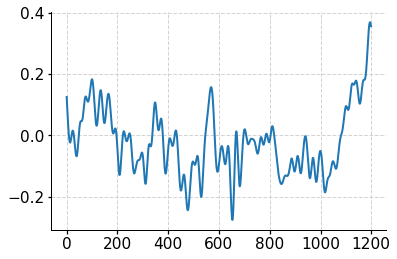

In [445]:
plt.plot(quick_filt(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_1_05_reuse/Echam_both.nc')['gm_tsurf']))

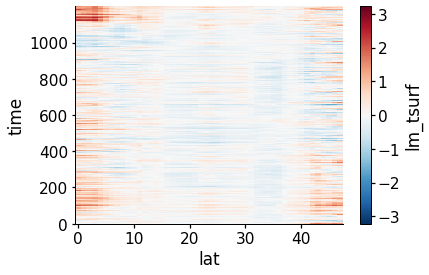

In [448]:
xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_1_05_reuse/Echam_both.nc')['lm_tsurf'].plot()

In [94]:
lmr_gmt=anomaly(lmr_gm['gmt'].mean(dim=('MCrun','members')))
phyda_gmt=anomaly(phyda['gmt_mn'])

In [146]:
#convert lmr time series to dataframe in order to use pyleoclim
lmr_df=lmr_gm['gmt'].mean(dim=('MCrun','members'))

In [ ]:
lmr_df.todata

In [144]:
import pyleoclim as pyleo

In [257]:
lr04_s

In [273]:
p2k_m['DA'].var()

<xarray.DataArray 'DA' ()>
array(0.00996029)

In [274]:
p2k_m['CPS'].var()

<xarray.DataArray 'CPS' ()>
array(0.01367816)

Total variance
CPS 0.01557306603592173
DA 0.012908471014851519
PCR 0.016044696162612504
BHM 0.05116765146951381
M08 0.02736063763714829
OIE 0.027102973701477847
PAI 0.03412207599812982


Text(0.5, 1.0, 'PSD (mtm) of GMT (800-1850 AD, not standardised)')

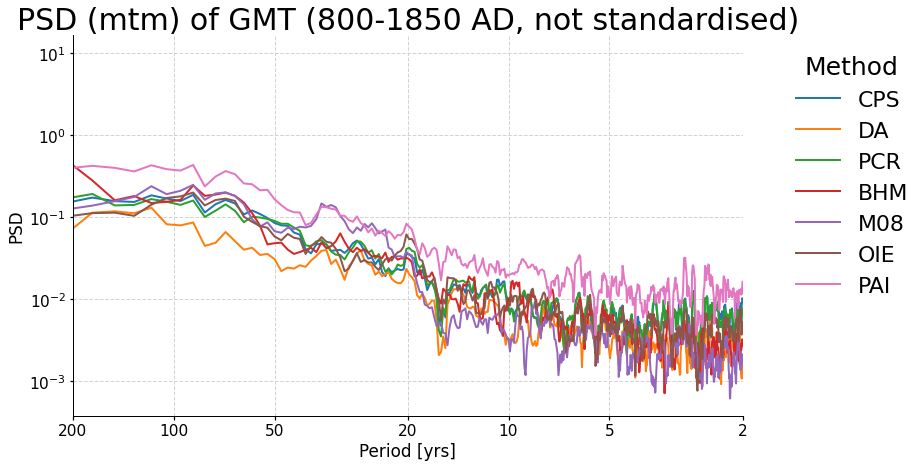

In [333]:
pages2k_2019='/home/mchoblet/lmr_phyda_output/pages2k_ngeo19_recons.nc'
pages2k=xr.open_dataset(pages2k_2019)
pages2k=pages2k.rename({'year':'time'})
pages2k['time']=time_phyda
#pages2k=pages2k.sel(time=slice('0800','2000'))
p2k_m=pages2k.mean('ens')
p2k_s=pages2k.std('ens')

#lr04_s_lmr=pyleo.Series(value=lmr_df.values[:1051],time=np.arange(800,1851,1),time_name='time',time_unit='year',label='lmr')

fix,axes=plt.subplots(1,1,figsize=(12,7))
start=799
end=1850
time=np.arange(start+1,end+1,1)
#[799:]
#np.arange(800,2001,1
#method='welch'
#method='periodogram'
method='mtm'

print('Total variance')
for v in ['CPS','DA','PCR','BHM','M08','OIE','PAI']:
    print(v,np.var(p2k_m[v].values[start:]))
    lr04_s=pyleo.Series(value=p2k_m[v].values[start:end],time=time,time_name='time',time_unit='year',label='other')
    #lr04_s.standardize().interp().spectral(method=method,settings={'scaling':'spectrum'}).plot(ax=axes,label=v)
    #without standardizing
    #lr04_s.spectral(method=method,settings={'standardize':False,'NW':4}).plot(ax=axes,label=v)
    lr04_s.spectral(method=method,settings={'standardize':False}).plot(ax=axes,label=v)
    #psd=pyleo.utils.spectral.welch(p2k_m[v].values[start:],lr04_s.time,scaling='density')
    #axes.plot(psd['freq'],psd['psd'],label=v)
    

plt.xlim(200,2)
plt.legend(bbox_to_anchor=(1.05, 1),title='Method',fontsize=22)
axes.get_legend().get_title().set_fontsize('25')
string='PSD ('+method+') of GMT (800-1850 AD, not standardised)'
plt.title(string,fontsize=30)
#plt.ylim(0.0001,1)


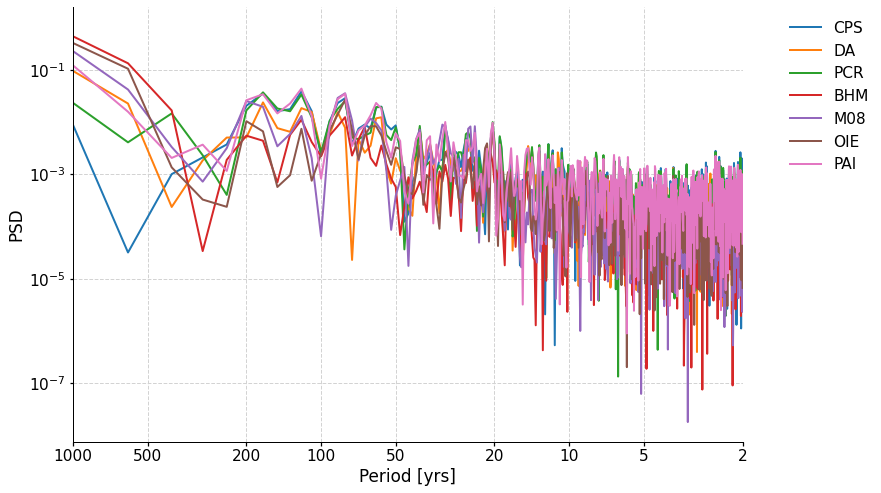

In [270]:
pages2k_2019='/home/mchoblet/lmr_phyda_output/pages2k_ngeo19_recons.nc'
pages2k=xr.open_dataset(pages2k_2019)
pages2k=pages2k.rename({'year':'time'})
pages2k['time']=time_phyda
#pages2k=pages2k.sel(time=slice('0800','2000'))
p2k_m=pages2k.mean('ens')
p2k_s=pages2k.std('ens')

#lr04_s_lmr=pyleo.Series(value=lmr_df.values[:1051],time=np.arange(800,1851,1),time_name='time',time_unit='year',label='lmr')

fix,axes=plt.subplots(1,1,figsize=(12,8))
start=799
time=np.arange(start+1,2001,1)
#[799:]
#np.arange(800,2001,1
method='welch'
#method='periodogram'

for v in ['CPS','DA','PCR','BHM','M08','OIE','PAI']:
    lr04_s=pyleo.Series(value=p2k_m[v].values[start:],time=time,time_name='time',time_unit='year',label='other')
    lr04_s.standardize().interp().spectral(method=method,settings={'scaling':'spectrum'}).plot(ax=axes,label=v)
    #psd=pyleo.utils.spectral.welch(p2k_m[v].values[start:],lr04_s.time,scaling='density')
    #axes.plot(psd['freq'],psd['psd'],label=v)
    
    
plt.legend(bbox_to_anchor=(1.05, 1))

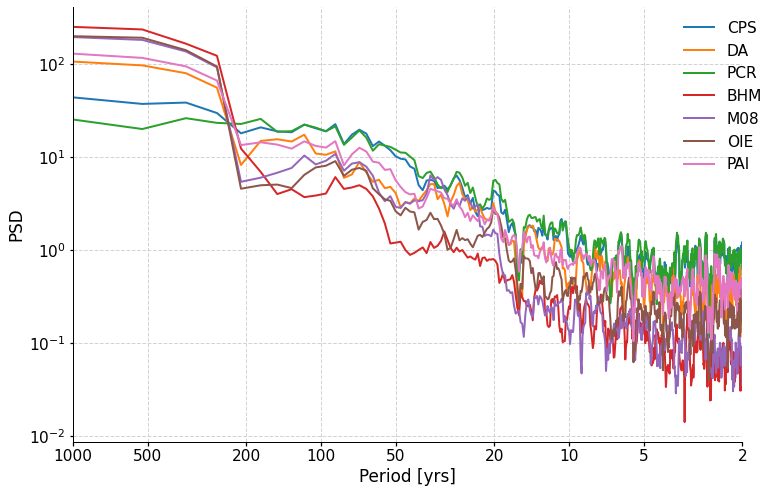

In [221]:
#lr04_s_lmr=pyleo.Series(value=lmr_df.values[:1051],time=np.arange(800,1851,1),time_name='time',time_unit='year',label='lmr')

fix,axes=plt.subplots(1,1,figsize=(12,8))

for v in ['CPS','DA','PCR','BHM','M08','OIE','PAI']:
    lr04_s=pyleo.Series(value=p2k_m[v].values[:1051],time=np.arange(800,1851,1),time_name='time',time_unit='year',label='other')
    lr04_s.standardize().interp().spectral(method='mtm').plot(ax=axes,label=v)
    
plt.legend(bbox_to_anchor=(1.05, 1))

In [ ]:
#lr04_s_lmr=pyleo.Series(value=lmr_df.values[:1051],time=np.arange(800,1851,1),time_name='time',time_unit='year',label='lmr')

fix,axes=plt.subplots(1,1,figsize=(12,8))

for v in ['CPS','DA','PCR','BHM','M08','OIE','PAI']:
    lr04_s=pyleo.Series(value=p2k_m[v].values[:1051],time=np.arange(800,1851,1),time_name='time',time_unit='year',label='other')
    lr04_s.standardize().interp().spectral(method='mtm').plot(ax=axes,label=v)
    
plt.legend(bbox_to_anchor=(1.05, 1))

<AxesSubplot:xlabel='Period [yrs]', ylabel='PSD'>

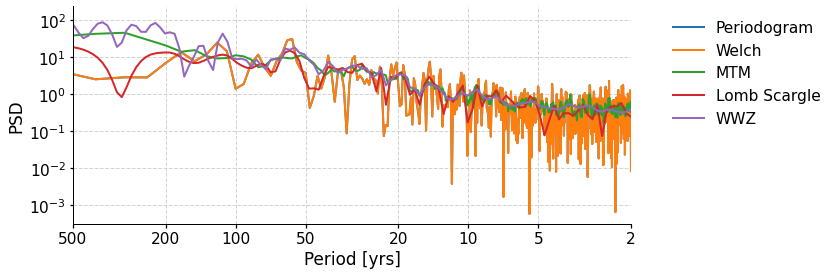

In [158]:
#with recent warming
PSD_p = lr04_s.standardize().interp().spectral(method='periodogram')
fig, ax = PSD_p.plot(label = 'Periodogram')
lr04_s.standardize().interp().spectral(method='welch').plot(ax=ax,label='Welch')
lr04_s.standardize().interp().spectral(method='mtm').plot(ax=ax,label='MTM')
lr04_s.standardize().spectral(method='lomb_scargle').plot(ax=ax,label='Lomb Scargle')
lr04_s.standardize().spectral(method='wwz').plot(ax=ax,label='WWZ',lgd_kwargs={'bbox_to_anchor':(1.05, 1)})

<AxesSubplot:xlabel='Period [yrs]', ylabel='PSD'>

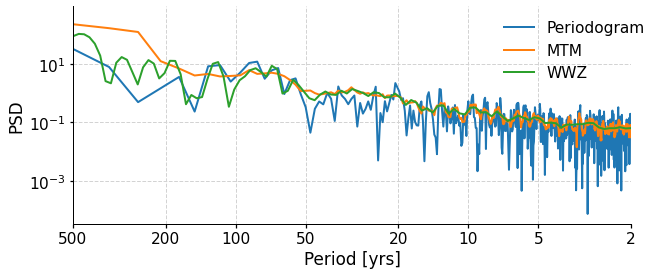

In [209]:
#without recent warming
#PSD_p = lr04_s.standardize().interp().spectral(method='periodogram')
fig, ax = PSD_p.plot(label = 'Periodogram')
#lr04_s.standardize().interp().spectral(method='welch').plot(ax=ax,label='Welch')
lr04_s.standardize().interp().spectral(method='mtm').plot(ax=ax,label='MTM')
#lr04_s.standardize().spectral(method='lomb_scargle').plot(ax=ax,label='Lomb Scargle')
lr04_s.standardize().spectral(method='wwz').plot(ax=ax,label='WWZ',lgd_kwargs={'bbox_to_anchor':(1.05, 1)})

<AxesSubplot:xlabel='Period [yrs]', ylabel='PSD'>

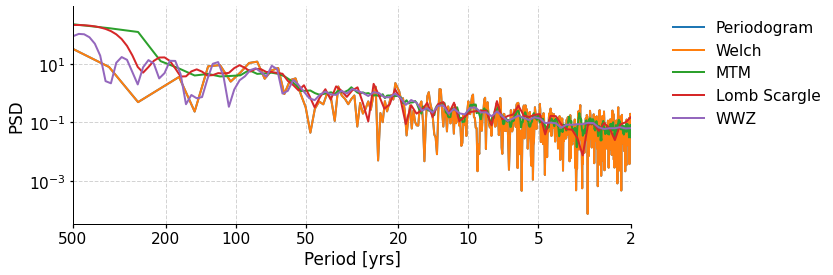

In [207]:
v='BHM'
lr04_s=pyleo.Series(value=p2k_m[v].values[:1051],time=np.arange(800,1851,1),time_name='time',time_unit='year',label='lmr')

PSD_p = lr04_s.standardize().interp().spectral(method='periodogram')
fig, ax = PSD_p.plot(label = 'Periodogram')
lr04_s.standardize().interp().spectral(method='welch').plot(ax=ax,label='Welch')
lr04_s.standardize().interp().spectral(method='mtm').plot(ax=ax,label='MTM')
lr04_s.standardize().spectral(method='lomb_scargle').plot(ax=ax,label='Lomb Scargle')
lr04_s.standardize().spectral(method='wwz').plot(ax=ax,label='WWZ',lgd_kwargs={'bbox_to_anchor':(1.05, 1)})


Performing spectral analysis on individual series: 100%|██████████| 200/200 [00:03<00:00, 50.85it/s]


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Period [yrs]', ylabel='PSD'>)

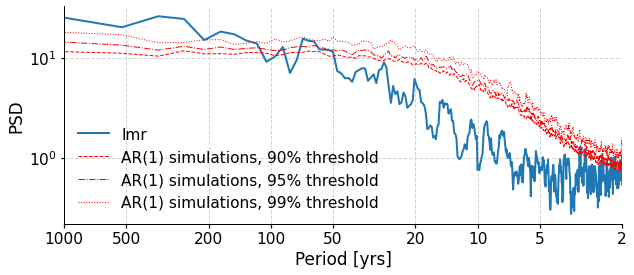

In [164]:
lr04_s.standardize().spectral('mtm').signif_test(qs=[0.90,0.95,0.99]).plot()

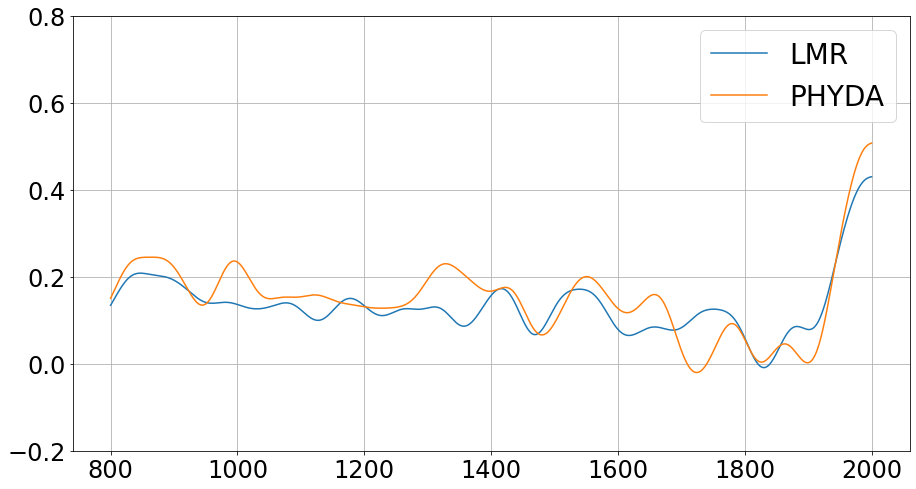

In [99]:
cutoff=1/100

plt.figure(figsize=(15,8))
plt.grid(True)
plt.plot(quick_filt(lmr_gmt,cutoff=cutoff),label='LMR')
plt.plot(quick_filt(phyda_gmt,cutoff=cutoff),label='PHYDA')
#phyda_gmt.plot(label='PHYDA')
plt.xticks(ticks=np.arange(0,1400,200),labels=list(map(str,np.arange(800,2001,200))),fontsize=24)
plt.yticks(np.arange(-0.2,1,0.2),fontsize=24)
plt.legend(fontsize=28)

In [73]:
np.corrcoef(lmr_gmt,phyda_gmt)

array([[1.        , 0.75152013],
       [0.75152013, 1.        ]])

In [77]:
np.corrcoef(quick_filt(lmr_gmt),quick_filt(phyda_gmt))

array([[1.        , 0.83855765],
       [0.83855765, 1.        ]])

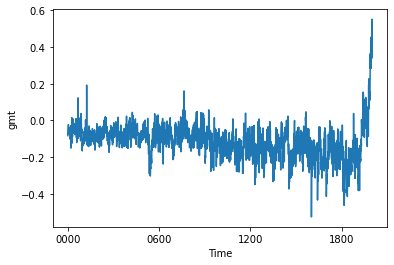

In [51]:
lmr_gm.mean(dim=('MCrun','members'))['gmt'].plot()

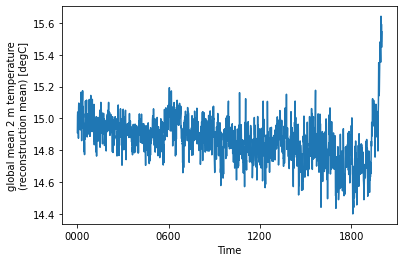

In [40]:
phyda['gmt_mn'].plot()

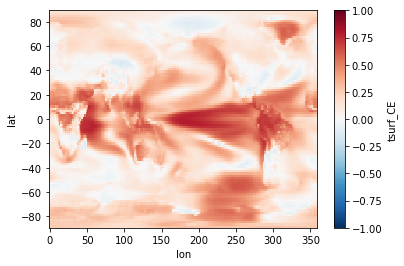

In [12]:
data=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_5_4/iCESM_target_iCESM_prior.nc')
data['tsurf_CE'].plot(vmax=1,vmin=-1,cmap='RdBu_r')

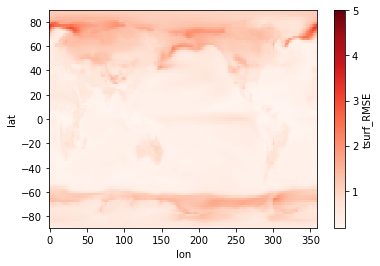

In [17]:
data['tsurf_RMSE'].plot(cmap='Reds',vmax=5)

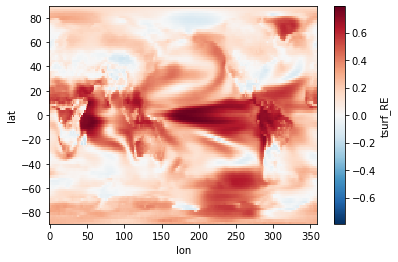

In [4]:
data['tsurf_RE'].plot()

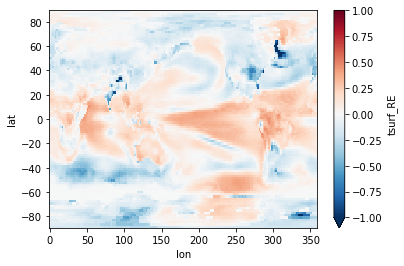

In [21]:
data2=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_5_4/iCESM_target_isoGSM_prior.nc')
data2['tsurf_RE'].plot(vmax=1,vmin=-1,cmap='RdBu_r')

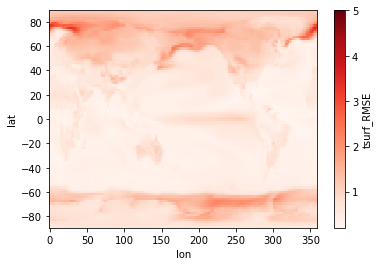

In [18]:
data2['tsurf_RMSE'].plot(cmap='Reds',vmax=5)

In [1]:
def regional_plot(data_0=None,path=None,var=None,ano=True,bounds=[[30,80],[310,60]],title='Temperature',anomaly_period=['1850','1900'],freq=100,start_y='0800',end_y='1999',vmax=10,vmin=-10,
                     cmap='RdBu_r', #BrBG_r for precipitation
                    figsize=(20,15),
                    size=100,
                    label=r'$\Delta$T [K]',
                    plotbox=None,maskocean=False):
    
    start=anomaly_period[0]
    end=anomaly_period[1]
        
    if data_0 is None:
        data_org=xr.open_dataset(path)
        data_0=data_org[var]

    data_0=data_0.sel(time=slice(start_y,end_y))

    data=data_0-data_0.sel(time=slice(start,end)).mean('time')
    data=data.resample(time=(str(freq)+'YS'),label='left').mean('time')

    #cut fields
    lat=data.lat
    lon=data.lon
    lats,lons=bounds[0],bounds[1]
    if lons[0]<lons[1]:    #selection of longitudes
        sel_lat = lat.where( (lat >= lats[0] ) & (lat <= lats[1]), drop=True)
        sel_lon = lon.where( (lon >= lons[0] ) & (lon <= lons[1]), drop=True)
    else:    #cross zero-meridian region option
        sel_lat = lat.where( (lat >= lats[0] ) & (lat <= lats[1]), drop=True)
        sel_lon_1 = lon.where( (lon >= lons[0] ), drop=True)
        sel_lon_2 = lon.where((lon <= lons[1]), drop=True)
        sel_lon=xr.concat([sel_lon_1,sel_lon_2],dim='lon')
    data_cut=data.sel(lat=sel_lat,lon=sel_lon)
    
    sns.set_theme(style="white")

    figsize=figsize
    fig, axes = plt.subplots(ncols=3,nrows=4,figsize=figsize,subplot_kw={'projection':ccrs.PlateCarree()})
    fig.suptitle(title,fontsize=40)

    for i,t in enumerate(data_cut.time):
        ax=axes.flatten()[i]
        
        if maskocean==True:
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='white'))
        
        ax.add_feature(cfeature.COASTLINE)
        ax.axes.gridlines(color='black',alpha=0.5,linestyle='--')

        ax.axes.xaxis.set_visible(True)
        ax.axes.yaxis.set_visible(True)
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])

        plot=data_cut.sel(time=t).plot(vmax=vmax,vmin=vmin,ax=ax,cmap=cmap,add_colorbar=False)

        year=data_cut.time.dt.year[i].values     
        
        #plot proxy values as scatter points
        """
        if proxies_ano==True:
            prox_i=proxies[i].dropna('site')
            scatter=ax.scatter(prox_i['lon'],prox_i['lat'],c=prox_i,s=size, cmap='PiYG', transform=ccrs.PlateCarree(), edgecolors='black',vmin=-2,vmax=2)
            string=str(year)+'-'+str(year+freq)+' ['+str(np.round(np.min(prox_i.values),1))+','+str(np.round(np.max(prox_i.values),1))+']'
        else:
            string=str(year)+'-'+str(year+freq)
        """    
        ax.set_ylabel('',fontsize=30,rotation=0)
        ax.set_xlabel('',fontsize=30,rotation=0)
        string=str(year)+'-'+str(year+freq)
        ax.set_title(string,fontsize=25)
        

        
        #ax=plt.gca()
        
        if plotbox==True:
            ax.plot([285.5,312.5,312.5,285.5,285.5],[-17.5,-17.5,-5,-5,-17.5], transform=ccrs.PlateCarree(),color='blue')
            
            #ax.relim()
            #ax.autoscale_view()
            """
            plotbox=[[-17.5,-5],[287.5,312.5]]
            width=np.abs(plotbox[1][1]-plotbox[1][0])
            height=np.abs(plotbox[0][0]-plotbox[0][1])
            
            xy=[plotbox[1][0],plotbox[0][0]]
            rectangle=mpatches.Rectangle(xy=xy, width=width, height=height,
                                    facecolor=None,
                                    edgecolor='blue',                                
                                    transform=ccrs.PlateCarree(),fill=False,clip_on=False)
            axes.flatten()[5].add_patch(rectangle)
            #ax.relim()
            #ax.autoscale_view()
            """
        #land-sea-mask
        
        
        
            
    
    """

    plotbox=[[-17.5,-5],[287.5,312.5]]
    width=np.abs(plotbox[1][1]-plotbox[1][0])
    height=np.abs(plotbox[0][0]-plotbox[0][1])

    xy=[plotbox[1][0],plotbox[0][0]]
    rectangle=mpatches.Rectangle(xy=xy, width=width, height=height,
                            facecolor=None,
                            edgecolor='blue',                                
                            transform=ccrs.PlateCarree(),fill=False)
    axes.flatten()[0].add_patch(rectangle)
    """
    
    p0=axes.flatten()[-3].get_position().get_points().flatten()
    p2=axes.flatten()[-1].get_position().get_points().flatten()

    from matplotlib import ticker

    #colormap variable
    ax_cbar1 = fig.add_axes([p0[0], p0[1]-0.05, (p2[2]-p0[0]), 0.02])
    cb=fig.colorbar(plot, cax=ax_cbar1, orientation='horizontal',cmap=cmap)
    cb.ax.tick_params(labelsize=20)
    tick_locator = ticker.MaxNLocator(nbins=6)
    cb.locator = tick_locator
    cb.update_ticks()
    cb.set_label(label,fontsize=30)

In [472]:
icesm=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_nopsm/iCESM.nc')
#icesm=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_nopsm/Echam.nc')

In [478]:
basepath='/home/mchoblet/paleoda/results/experiments/thesis_6_2_nopsm/'
models=['iCESM','Echam','GISS','isoGSM','iHadCM3']

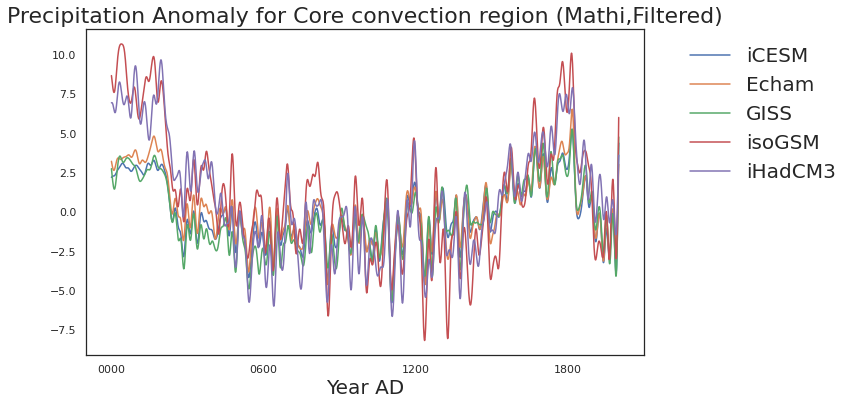

In [484]:
plt.figure(figsize=(10,6))
for m in models:
    data=xr.open_dataset(basepath+m+'.nc')['prec_mean']
    start=0
    plt.plot(anomaly(data,start='0800',end='1850')[start:].time,quick_filt(utils.regionalmean(anomaly(data,start='0850',end='1850'),[-17.5,-5],[287.5,312.5])[start:],cutoff=1/30),label=m)


plt.title('Precipitation Anomaly for Core convection region (Mathi,Filtered)',fontsize=22)
plt.xlabel('Year AD', fontsize=20)
plt.legend(fontsize=20,bbox_to_anchor=(1.05, 1))    

Text(0.5, 0, 'Year AD')

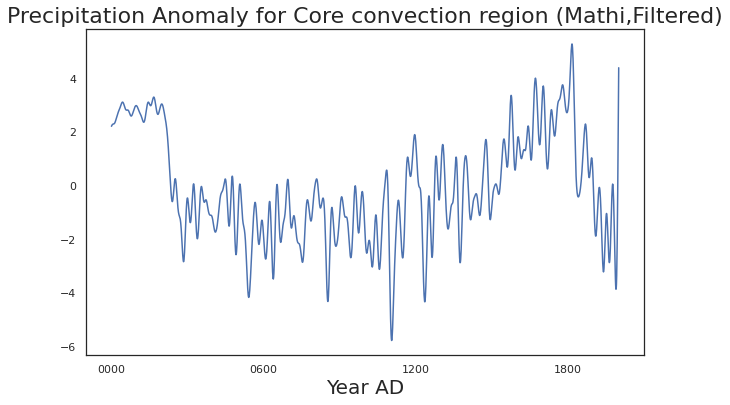

In [473]:
plt.figure(figsize=(10,6))
start=0
plt.plot(anomaly(icesm['prec_mean'],start='0800',end='1850')[start:].time,quick_filt(utils.regionalmean(anomaly(icesm['prec_mean'],start='0850',end='1850'),[-17.5,-5],[287.5,312.5])[start:],cutoff=1/30))
plt.title('Precipitation Anomaly for Core convection region (Mathi,Filtered)',fontsize=22)
plt.xlabel('Year AD', fontsize=20)

In [6]:
bounds_europe=[[30,85],[310,50]]
bounds_global=[[-90,90],[0,360]]
bounds_sa=[[-57.5,15],[270,330]]

monsoon_region=[[-17.5,-5],[287.5,312.5]]

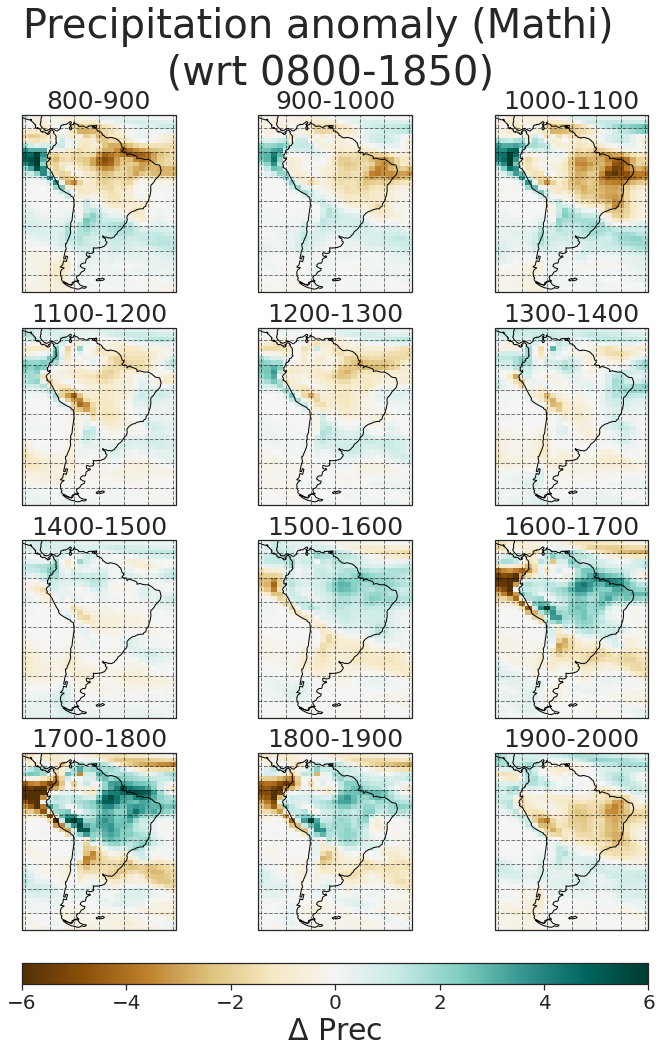

In [487]:
icesm=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_nopsm/iCESM.nc')
regional_plot(icesm['prec_mean'],bounds=bounds_sa,vmax=6,vmin=-6,
              title='Precipitation anomaly (Mathi) \n (wrt 0800-1850)',  cmap='BrBG',label=r'$\Delta$ Prec',
              figsize=(12,15),anomaly_period=['0800','1850'],plotbox=False,
             maskocean=False)

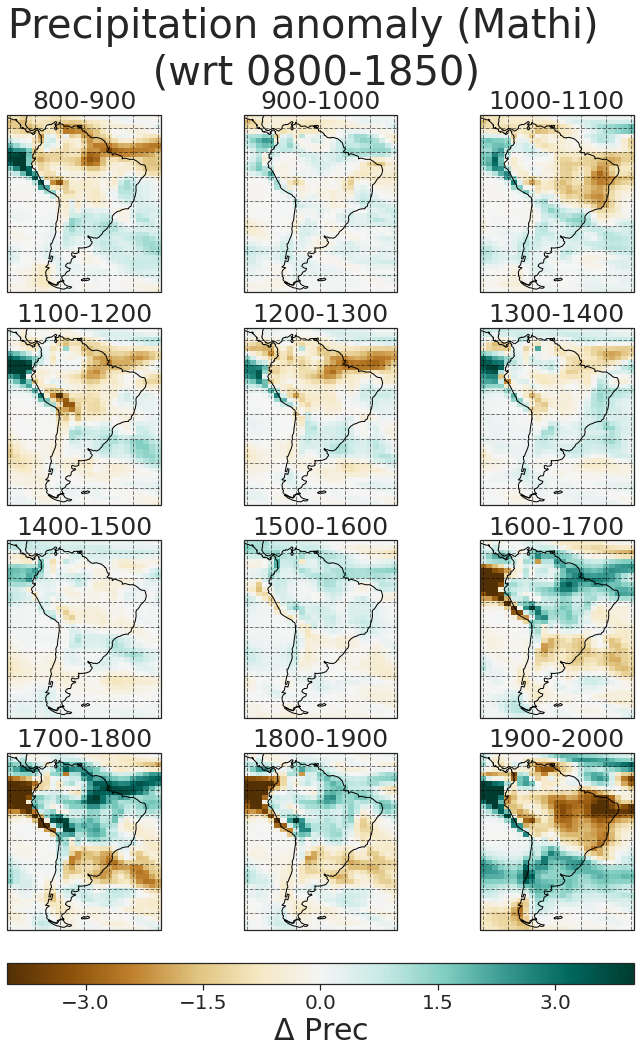

In [493]:
icesm=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_psm/iCESM.nc')
regional_plot(icesm['prec_mean'],bounds=bounds_sa,vmax=4,vmin=-4,
              title='Precipitation anomaly (Mathi) \n (wrt 0800-1850)',  cmap='BrBG',label=r'$\Delta$ Prec',
              figsize=(12,15),anomaly_period=['0800','1850'],plotbox=False,
             maskocean=False)

In [495]:
8*10**(-7)*24*60*60*31

2.14272

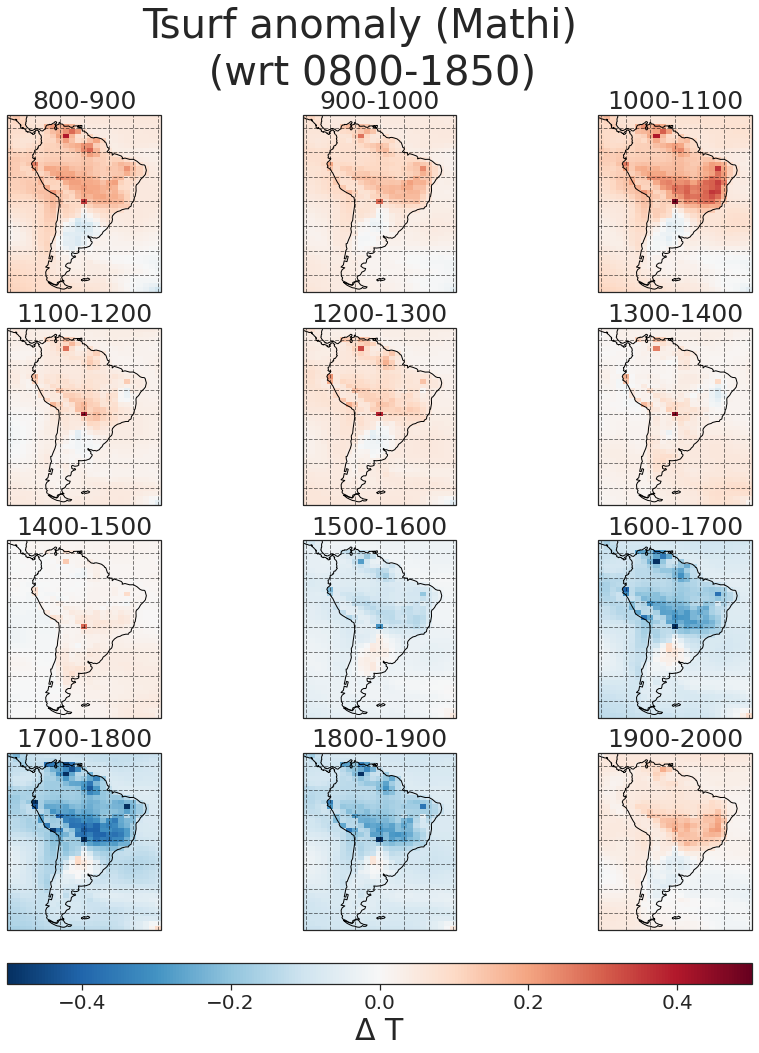

In [7]:
icesm=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_nopsm/iCESM.nc')
regional_plot(icesm['tsurf_mean'],bounds=bounds_sa,vmax=0.5,vmin=-0.5,
              title='Tsurf anomaly (Mathi) \n (wrt 0800-1850)',  cmap='RdBu_r',label=r'$\Delta$ T',
              figsize=(15,15),anomaly_period=['0800','1850'],plotbox=False,
             maskocean=False)

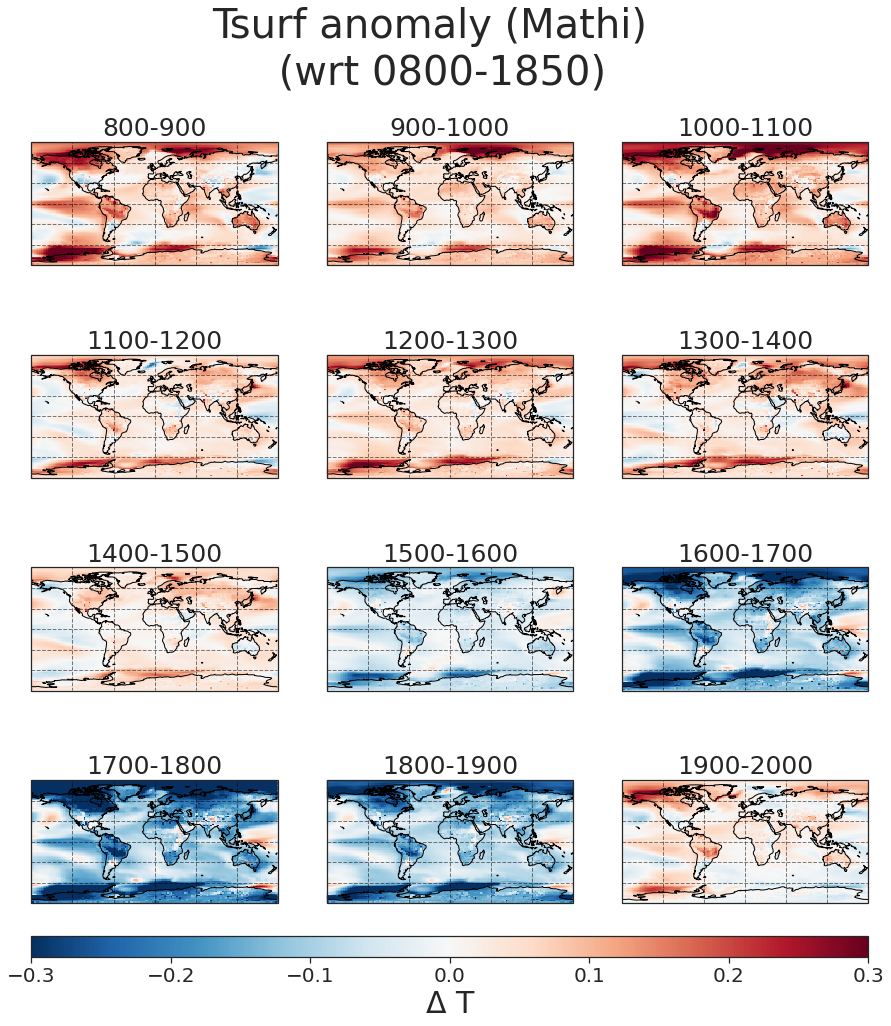

In [486]:
regional_plot(icesm['tsurf_mean'],bounds=bounds_global,vmax=0.3,vmin=-0.3,
              title='Tsurf anomaly (Mathi) \n (wrt 0800-1850)',  cmap='RdBu_r',label=r'$\Delta$ T',
              figsize=(15,15),anomaly_period=['0800','1850'],plotbox=False,
             maskocean=False)

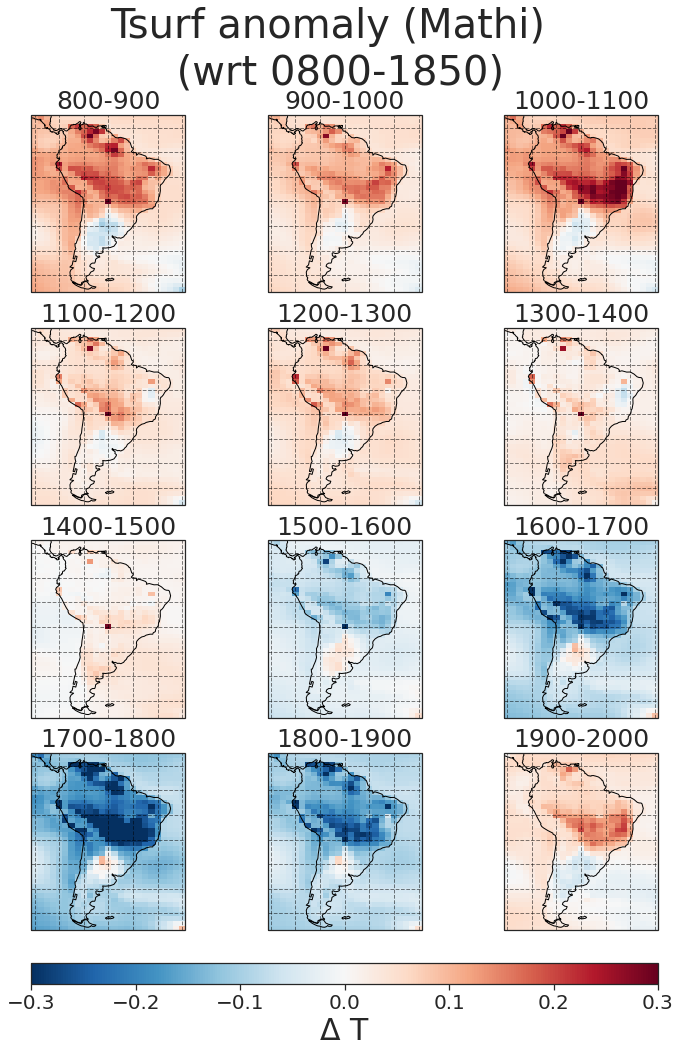

In [476]:
regional_plot(icesm['tsurf_mean'],bounds=bounds_sa,vmax=0.3,vmin=-0.3,
              title='Tsurf anomaly (Mathi) \n (wrt 0800-1850)',  cmap='RdBu_r',label=r'$\Delta$ T',
              figsize=(12,15),anomaly_period=['0800','1850'],plotbox=False,
             maskocean=False)